In [34]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score
shap.initjs()
import hvplot.pandas

print(mpl.__version__)

3.5.2


# Adult Census Income

### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.


### Attribute Information:

**Listing of attributes:**

target: >50K, <=50K.

inputs:
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
# https://archive.ics.uci.edu/ml/datasets/adult

seed = 7
X_display, y_display = shap.datasets.adult(display=True)
X, y = shap.datasets.adult(display=False)
# Fixing some types
y = y.astype(np.uint8)
y_display = y_display.astype(np.uint8)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    'eta': 0.02,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'seed': seed
}
model = xgboost.train(params, xgb_train, 5000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-logloss:0.68230
[1000]	test-logloss:0.28195
[2000]	test-logloss:0.27875
[3000]	test-logloss:0.27846
[4000]	test-logloss:0.27930
[4999]	test-logloss:0.28015


In [3]:
y_pred = (model.predict(xgb_test) >= 0.5).astype(np.uint8)
print(f'# of train data: {xgb_train.num_row()}')
print(f'# of train data: {xgb_test.num_row()}')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=y_pred))

# of train data: 26048
# of train data: 6513
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4951
           1       0.78      0.66      0.71      1562

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [4]:
idx = np.arange(len(y_test))
sample_idx = np.concatenate((idx[y_test == 0][:5], idx[y_test == 1][:5]))

In [5]:
explainer = shap.TreeExplainer(model, data=X_test)
shap_values = explainer.shap_values(X_test.iloc[sample_idx, :])

In [6]:
i = sample_idx[0]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

In [7]:
i = sample_idx[6]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

calculate all shap values + shape interaction values

In [146]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

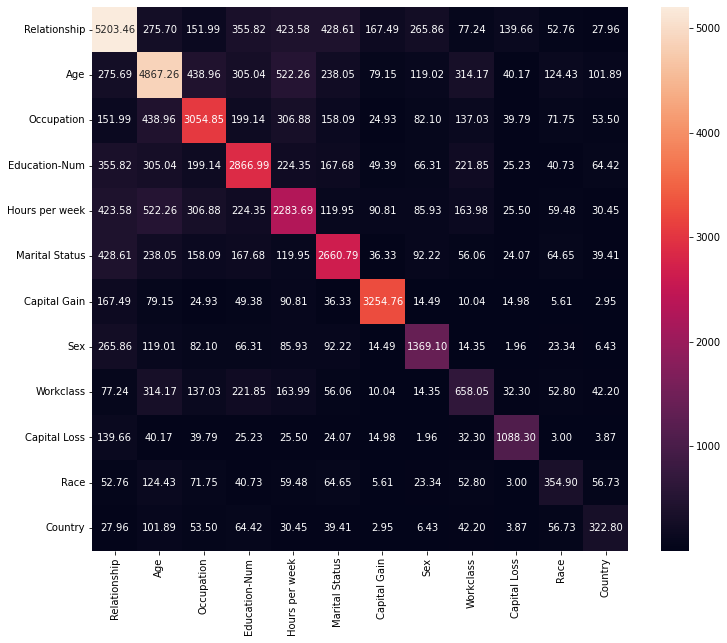

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()
# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).sum(0)
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
sns.heatmap(data=pd.DataFrame(tmp2, index=X_test.columns[inds], columns=X_test.columns[inds]), annot=True, fmt='.2f', ax=ax)
plt.show()

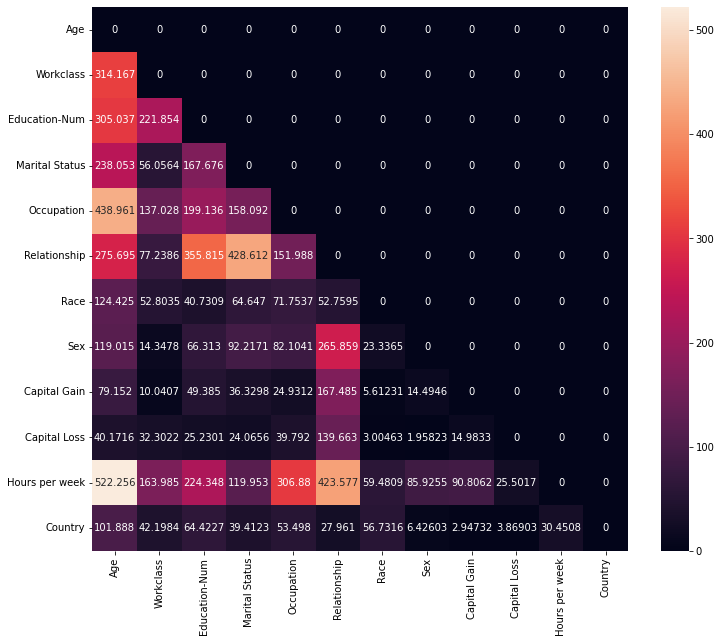

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()

for i in range(len(siv)):
    r, c = np.triu_indices(12)
    siv[i, r, c] = 0.0

# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).sum(0)
sns.heatmap(data=pd.DataFrame(tmp, index=X_test.columns, columns=X_test.columns), annot=True, fmt='g', ax=ax)
plt.show()

In [160]:
# check shap_values are equal to main effect + interaction effect
print(shap_values.shape, shap_interaction_values.shape)
N, M = shap_values.shape

siv = shap_interaction_values.copy()
r_diag, c_diag = np.diag_indices(M)
for i in range(N):
    siv[i, r_diag, c_diag] = 0.0

print('SHAP values - (main effect + interaction effect) = ', end='')
print((shap_values.values - (shap_interaction_values[:, r_diag, c_diag] + siv.sum(2))).round(4).sum())

(6513, 12) (6513, 12, 12)
SHAP values - (main effect + interaction effect) = 0.0


# Analysis

In [62]:
import itertools
from collections import defaultdict

idx_dict = defaultdict(dict)
df_y = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
correct = df_y[df_y['y_true'] == df_y['y_pred']]
incorrect = df_y[df_y['y_true'] != df_y['y_pred']]

idx_dict[('correct', 0)] = (correct.loc[correct['y_true'] == 0].index).values
idx_dict[('correct', 1)] = (correct.loc[correct['y_true'] == 1].index).values
idx_dict[('incorrect', 0)] = (incorrect.loc[incorrect['y_true'] == 0].index).values
idx_dict[('incorrect', 1)] = (incorrect.loc[incorrect['y_true'] == 1].index).values

shap_dict = defaultdict(dict)

explainer = shap.TreeExplainer(model)
for c, label in itertools.product(['correct', 'incorrect'], range(2)):
    shap_dict['data'][(c, label)] = X_test.iloc[idx_dict[(c, label)]]
    shap_dict['y_true'][(c, label)] = df_y.loc[idx_dict[(c, label)], 'y_true']
    shap_dict['y_pred'][(c, label)] = df_y.loc[idx_dict[(c, label)], 'y_pred']
    shap_dict['shap'][(c, label)] = explainer(shap_dict['data'][(c, label)])
    shap_dict['shap_interaction'][(c, label)] = explainer.shap_interaction_values(shap_dict['data'][(c, label)])

model thinks the number of samples are not enough 

## Label = 0

In [23]:
# shap_values
label = 0
data_true = shap_dict['data'][('correct', label)]
sv_true = shap_dict['shap'][('correct', label)]
siv_true = shap_dict['shap_interaction'][('correct', label)]

data_false = shap_dict['data'][('incorrect', label)]
sv_false = shap_dict['shap'][('incorrect', label)]
siv_false = shap_dict['shap_interaction'][('incorrect', label)]

Average Effect: SHAP values

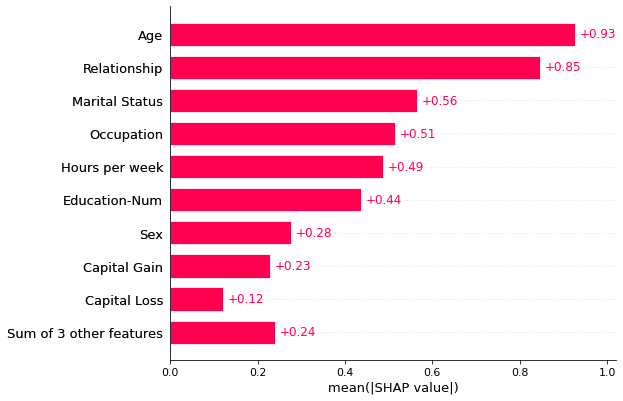

In [8]:
shap.plots.bar(sv_true)  # correct

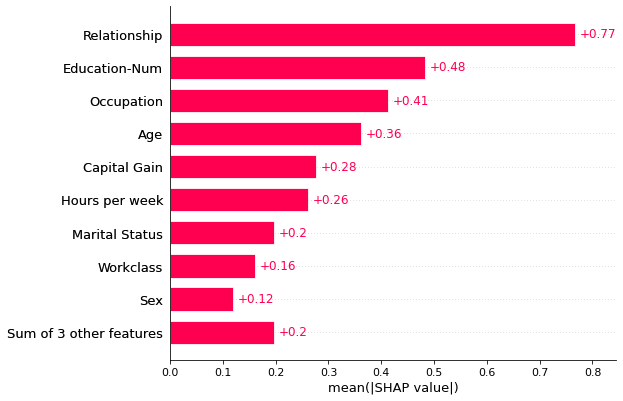

In [9]:
shap.plots.bar(sv_false)  # incorrect

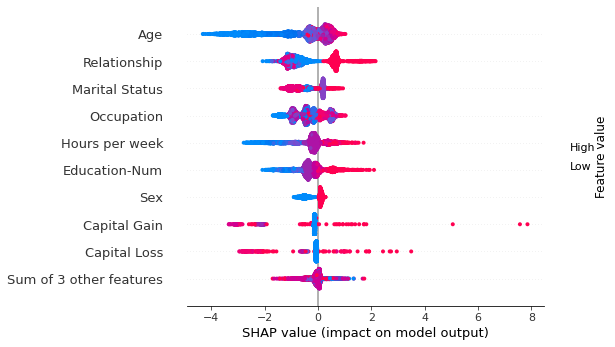

In [18]:
shap.plots.beeswarm(sv_true, order=sv_true.abs.mean(0))

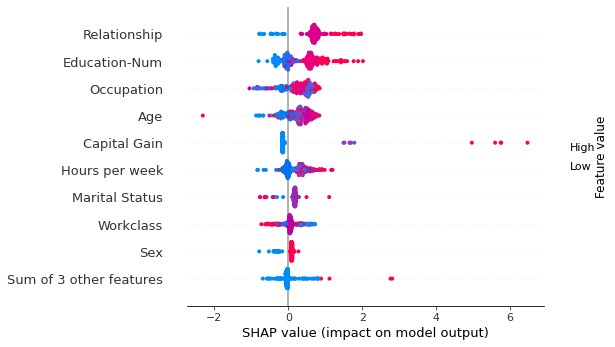

In [19]:
shap.plots.beeswarm(sv_false, order=sv_false.abs.mean(0))

Interaction comparing

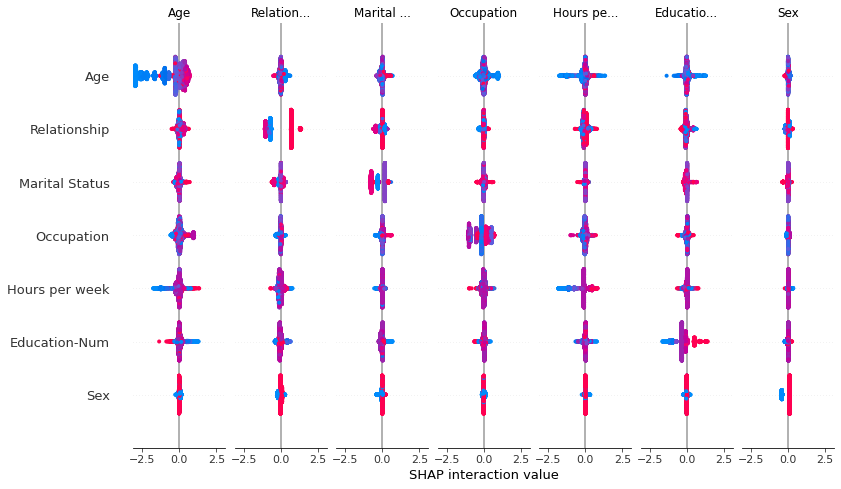

In [24]:
shap.summary_plot(siv_true, data_true)

In [ ]:
data_true.hvplot.scatter(x='age')

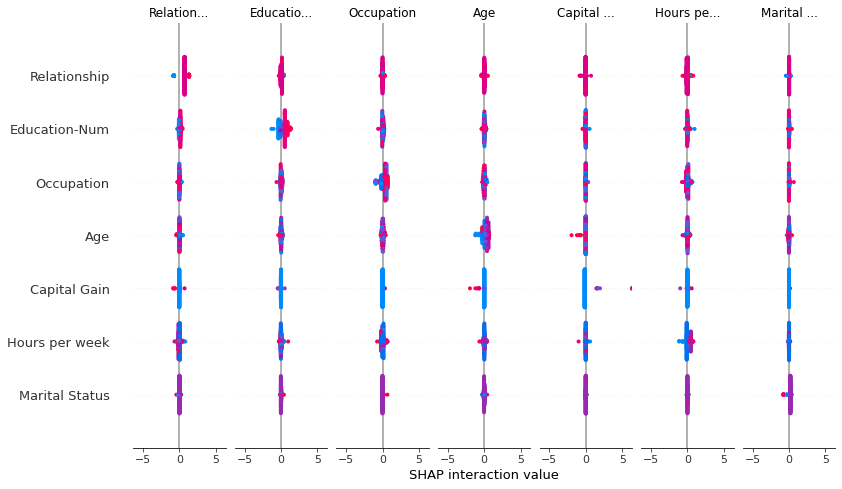

In [36]:
shap.summary_plot(siv_false, data_false)

dependency plots

In [70]:
siv_true

(4663, 12, 12)

In [75]:
data_true

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
18329,39.0,4,10.0,0,4,1,4,0,0.0,625.0,40.0,39
13225,22.0,4,10.0,2,8,4,4,1,0.0,0.0,35.0,39
6837,23.0,7,8.0,4,4,0,4,1,0.0,0.0,40.0,39
29132,50.0,6,13.0,2,12,4,4,1,0.0,0.0,8.0,39
18728,58.0,2,13.0,0,10,0,4,0,0.0,0.0,50.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
23959,19.0,4,10.0,4,1,3,4,0,0.0,0.0,20.0,39
30638,25.0,5,9.0,2,12,4,4,1,0.0,0.0,60.0,0
6640,18.0,0,10.0,4,0,3,4,0,0.0,0.0,6.0,39
19186,23.0,4,4.0,4,7,3,2,0,0.0,0.0,40.0,6


https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

In [ ]:
def batch_tril_indexing(A, dim=1, cols=None):
    rt_pd = False if cols is None else True
    k = A.shape[dim]
    r, c = np.tril_indices(k, -1)
    if rt_pd:
        cs = list(zip(*(cols[r], cols[c])))
        return pd.DataFrame(A[:, r, c], columns=cs)
    else:
        return A[:, r, c]

In [48]:
siv_true_dense = batch_tril_indexing(siv_true, dim=1, cols=X_test.columns)
siv_false_dense = batch_tril_indexing(siv_false, dim=1, cols=X_test.columns)

In [53]:
siv_true_dense.abs().describe().T.sort_values('mean', ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
"(Hours per week, Age)",4663.0,0.096299,0.164956,0.000021,0.013983,0.036264,0.098580,0.890346
"(Relationship, Marital Status)",4663.0,0.086040,0.085150,0.000013,0.004860,0.076997,0.099204,0.312127
"(Occupation, Age)",4663.0,0.078626,0.101123,0.000008,0.019831,0.042280,0.095470,0.498648
"(Hours per week, Relationship)",4663.0,0.068204,0.044509,0.000871,0.039074,0.056051,0.083516,0.392371
"(Relationship, Education-Num)",4663.0,0.057874,0.061280,0.000013,0.019292,0.036121,0.061315,0.331877
"(Workclass, Age)",4663.0,0.053581,0.072138,0.000002,0.019425,0.034351,0.051493,0.515162
"(Education-Num, Age)",4663.0,0.053470,0.081815,0.000003,0.009992,0.025151,0.059694,0.681982
"(Relationship, Age)",4663.0,0.050236,0.052798,0.000009,0.011459,0.029632,0.069008,0.317757
"(Sex, Relationship)",4663.0,0.046459,0.037847,0.007350,0.011939,0.037946,0.091623,0.145755
"(Hours per week, Occupation)",4663.0,0.044671,0.045141,0.000047,0.016678,0.028379,0.062952,0.503595


In [54]:
siv_false_dense.abs().describe().T.sort_values('mean', ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
"(Hours per week, Occupation)",288.0,0.061690,0.062377,0.000234,0.022041,0.051893,0.077366,0.377765
"(Hours per week, Relationship)",288.0,0.056285,0.046442,0.005893,0.035732,0.045928,0.055451,0.400055
"(Relationship, Education-Num)",288.0,0.048932,0.029742,0.000218,0.023687,0.043296,0.067176,0.210713
"(Occupation, Age)",288.0,0.039577,0.032697,0.000111,0.017170,0.035418,0.050853,0.207962
"(Hours per week, Age)",288.0,0.036664,0.042416,0.000006,0.008922,0.023628,0.046940,0.331686
"(Workclass, Age)",288.0,0.034971,0.034462,0.000018,0.016504,0.023136,0.036760,0.241338
"(Occupation, Education-Num)",288.0,0.030395,0.028319,0.000102,0.012624,0.022428,0.040914,0.307299
"(Hours per week, Education-Num)",288.0,0.029033,0.041880,0.000041,0.010710,0.018291,0.034083,0.493724
"(Education-Num, Workclass)",288.0,0.029009,0.026471,0.000008,0.009567,0.026273,0.035578,0.191349
"(Education-Num, Age)",288.0,0.028915,0.032191,0.000061,0.008125,0.017356,0.036058,0.191812


In [35]:
data_true.hvplot.hist(y='Age', bins=20)

:Histogram   [Age]   (Age_count)

In [37]:
data_false.hvplot.hist(y='Age', bins=20)

:Histogram   [Age]   (Age_count)

In [28]:
data_false.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,288.0,44.770832,10.304235,25.0,36.75,44.0,51.00,90.0
Workclass,288.0,3.875000,1.464445,0.0,4.00,4.0,4.00,7.0
Education-Num,288.0,11.854167,2.005111,4.0,10.00,13.0,13.00,16.0
Marital Status,288.0,2.065972,0.552935,0.0,2.00,2.0,2.00,6.0
Occupation,288.0,7.684028,4.179862,0.0,4.00,10.0,12.00,14.0
Relationship,288.0,3.888889,0.941576,0.0,4.00,4.0,4.00,5.0
Race,288.0,3.760417,0.792976,0.0,4.00,4.0,4.00,4.0
Sex,288.0,0.892361,0.310463,0.0,1.00,1.0,1.00,1.0
Capital Gain,288.0,425.215271,3014.191162,0.0,0.00,0.0,0.00,41310.0
Capital Loss,288.0,33.833332,234.085327,0.0,0.00,0.0,0.00,1902.0


틀린 것들의 sample들을 모아서 다시 boosting ensemble? 대신 이번에는 tree 분기를 맞게 맞춘 샘들을의 피처 중요도가 커지는 방향으로 ?

## Label == 1

In [42]:
def batch_tril_indexing(A, dim=1, cols=None):
    rt_pd = False if cols is None else True
    k = A.shape[dim]
    r, c = np.tril_indices(k, -1)
    if rt_pd:
        cs = list(zip(*(cols[r], cols[c])))
        return pd.DataFrame(A[:, r, c], columns=cs)
    else:
        return A[:, r, c]

In [44]:
siv_true_dense = batch_tril_indexing(siv_true, dim=1, cols=X_test.columns)
siv_true_dense

,"(Workclass, Age)","(Education-Num, Age)","(Education-Num, Workclass)","(Marital Status, Age)","(Marital Status, Workclass)","(Marital Status, Education-Num)","(Occupation, Age)","(Occupation, Workclass)","(Occupation, Education-Num)","(Occupation, Marital Status)",...,"(Country, Workclass)","(Country, Education-Num)","(Country, Marital Status)","(Country, Occupation)","(Country, Relationship)","(Country, Race)","(Country, Sex)","(Country, Capital Gain)","(Country, Capital Loss)","(Country, Hours per week)"
0,0.025938,0.002009,-0.007029,-0.157218,-0.007111,-0.026619,-0.033413,0.028619,-0.025211,0.025257,...,0.001598,-0.006362,-0.005914,-0.001272,0.000727,-0.003016,0.000285,1.231581e-05,-0.000256,-0.001076
1,-0.038652,0.020911,-0.007085,0.001821,0.002129,0.003630,0.468868,-0.006445,0.005128,-0.003581,...,0.001794,-0.007187,-0.000300,-0.001857,-0.000125,-0.004105,0.000378,-4.893541e-05,0.000135,0.002626
2,0.327300,0.405183,0.330101,-0.014333,0.015391,0.001086,-0.041491,-0.031653,-0.008460,-0.017522,...,0.001315,-0.000107,0.005741,-0.001306,-0.002906,-0.003105,-0.000090,-3.718585e-05,0.000130,-0.001930
3,-0.111667,-0.006674,-0.047047,-0.013631,-0.008854,-0.004565,-0.065434,0.062508,0.053198,-0.005327,...,-0.000520,0.001794,-0.000188,-0.002810,-0.000306,-0.005096,0.000417,4.842877e-06,0.000141,-0.000656
4,-0.033776,-0.028265,-0.054430,0.093100,-0.011333,0.032582,-0.076907,-0.012512,-0.008232,-0.028281,...,-0.009609,0.001588,-0.004373,-0.004833,0.001307,-0.003471,0.001155,2.336502e-05,0.000167,-0.000843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4658,-0.023527,-0.007523,-0.007433,-0.013651,-0.007097,-0.019402,-0.156947,-0.005977,-0.004788,-0.057850,...,0.001663,-0.006353,0.004230,0.002491,-0.001937,-0.002867,-0.000690,-5.151331e-05,0.000131,0.000471
4659,0.086452,0.030259,0.005841,0.052435,0.000026,0.009811,-0.239693,0.070256,-0.012497,-0.007245,...,-0.079842,0.090484,0.021301,-0.073220,0.007255,0.041897,0.007526,1.801178e-04,-0.005625,-0.200258
4660,-0.363184,-0.033498,0.072293,-0.022807,-0.031756,-0.020119,-0.249718,-0.018094,-0.008711,-0.053203,...,-0.009713,-0.005006,0.004044,-0.000269,-0.001410,-0.002720,0.000064,-5.099177e-05,0.000127,0.004457
4661,-0.069788,0.610605,-0.085657,0.043236,-0.011656,0.288547,0.045090,-0.001929,0.068129,-0.011853,...,-0.018759,0.065629,-0.107625,0.025109,0.022678,-0.068487,-0.001199,2.533495e-04,-0.001069,-0.013381


In [47]:
siv_true_dense.describe().T.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
"(Hours per week, Age)",4663.0,-0.052560,0.183638,-0.890346,-0.070341,-0.005567,0.020646,0.672473
"(Relationship, Marital Status)",4663.0,-0.044086,0.112743,-0.312127,-0.093393,0.002439,0.017038,0.168097
"(Sex, Relationship)",4663.0,-0.019221,0.056761,-0.123172,-0.083950,-0.010032,0.016222,0.145755
"(Hours per week, Relationship)",4663.0,-0.017910,0.079454,-0.353277,-0.066409,-0.045109,0.031369,0.392371
"(Workclass, Age)",4663.0,-0.017668,0.088109,-0.435117,-0.044936,-0.023100,0.018205,0.515162
...,...,...,...,...,...,...,...,...
"(Occupation, Education-Num)",4663.0,0.006511,0.042471,-0.319091,-0.010399,0.012184,0.024017,0.231291
"(Hours per week, Sex)",4663.0,0.006610,0.033101,-0.120756,-0.004044,0.000747,0.003092,0.170621
"(Occupation, Age)",4663.0,0.013798,0.127353,-0.303132,-0.043143,-0.001114,0.040923,0.498648
"(Education-Num, Age)",4663.0,0.017858,0.096096,-0.681982,-0.019282,0.002378,0.035891,0.648192
